In [1]:
import matplotlib
#matplotlib.use('Agg') # necessary for linux kernal
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
from keras import models
from sklearn.metrics import accuracy_score

from data_helper import readImg

def IoUcheck(img_input, img_output):

    logic_and = np.sum(np.logical_and(img_output, img_input))
    logic_or = np.sum(np.logical_or(img_output, img_input))

    return logic_and/logic_or

# function to load a saved model
def LoadModel(model_json):
    from keras.models import model_from_json
    json_file = open(model_json)
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model

def rescaleImg(image_arr):
    
    if image_arr.shape[0] % 8 != 0:
        n = image_arr.shape[0] % 8
        new_x = image_arr.shape[0] - n
    else:
        new_x = image_arr.shape[0]

    if image_arr.shape[1] % 8 != 0:
        n = image_arr.shape[1] % 8
        new_y = image_arr.shape[1] - n
    else:
        new_y = image_arr.shape[1]

    image_arr = image_arr[:new_x, :new_y]
    
    return image_arr

Using TensorFlow backend.


In [2]:
def testIndependet(fn, target, inpath, outpath, model_ex1):
    
    image_arr = readImg(inpath + fn)
    #print(image_arr.shape)
    image_arr = rescaleImg(image_arr)
    #print(image_arr.shape)
    
    image_tar = readImg(inpath + target)
    #print(image_tar.shape)
    image_tar = rescaleImg(image_tar)
    #print(image_tar.shape)
    
    conc2 = np.reshape(model_ex1.predict(np.reshape(image_arr, (1, image_arr.shape[0], image_arr.shape[1], 1))), 
                       (image_arr.shape[0], image_arr.shape[1]))
    
    acc = accuracy_score(image_tar.flatten().astype(bool), (conc2 > 0.5).flatten())
    iou = IoUcheck(image_tar.flatten().astype(bool), (conc2 > 0.5).flatten())
    print('accuracy:', acc)
    print('IoU:', iou)
    
    fig = plt.figure(figsize=(image_arr.shape[1] / 1000, image_arr.shape[0] / 1000), dpi=100, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    plt.imshow(conc2)
    fig.savefig(outpath + fn[:-4] + '_out.png', dpi=1000)
    
    
    fig = plt.figure(figsize=(image_arr.shape[1] / 1000, image_arr.shape[0] / 1000), dpi=100, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    conc2 = conc2 > 0.5
    plt.imshow(conc2, cmap='gray')
    fig.savefig(outpath + fn[:-4] + '_out_bw.png', dpi=1000)
    
    return acc, iou

In [6]:
def predict_15k(tmpPath, testPath, outPath, 
                fn_input, fn_target):
    
    
    image_arrA = readImg(testPath + fn_input)
    image_arrB = readImg(testPath + fn_target)

    print("15k", 'Example: ')

    Accuracy = accuracy_score(image_arrB.flatten().astype(bool), 
                              image_arrA.flatten().astype(bool))

    IntOverUnion = IoUcheck(image_arrB.flatten().astype(bool), 
                            image_arrA.flatten().astype(bool))
    
    print('accuracy:', Accuracy)
    print('IoU:', IntOverUnion)

    model_ex1 = LoadModel(tmpPath + "model_ex1.json")
    model_ex1.load_weights(tmpPath + "weights_model_ex1.h5")
    acc, iou = testIndependet(fn_input, fn_target, testPath, outPath, model_ex1)
    
    return [[Accuracy, IntOverUnion], [acc, iou]]


def predict_scale(tmpPath, testPath, outPath, scale):
    
    fns = os.listdir(testPath)
    fn_input  = [fn for fn in fns if 'geb_clip' in fn][0]
    fn_target = [fn for fn in fns if str(scale) in fn][0]
    print('Input and Target:', fn_input, fn_target)

    image_arrA = readImg(testPath + fn_input)
    image_arrB = readImg(testPath + fn_target)

    print(str(scale), 'Example: ')

    Accuracy = accuracy_score(image_arrB.flatten().astype(bool), 
                              image_arrA.flatten().astype(bool))

    IntOverUnion = IoUcheck(image_arrB.flatten().astype(bool), 
                            image_arrA.flatten().astype(bool))
    
    print('accuracy:', Accuracy)
    print('IoU:', IntOverUnion)

    model_ex1 = LoadModel(tmpPath + "model_ex1.json")
    model_ex1.load_weights(tmpPath + "weights_model_ex1.h5")
    acc, iou = testIndependet(fn_input, fn_target, testPath, outPath, model_ex1)
    
    return [[Accuracy, IntOverUnion], [acc, iou]]

15k Example: 
accuracy: 0.976413099134
IoU: 0.885579034522
accuracy: 0.987077294686
IoU: 0.936052592261
15k Example: 
accuracy: 0.982896331738
IoU: 0.926101517386
accuracy: 0.989783653846
IoU: 0.955156569095


,Input vs Target (Test1),Prediction vs Target (Test1),Input vs Target (Test2),Prediction vs Target (Test2)
Metrics,,,,
Accuracy,0.976413,0.987077,0.982896,0.989784
IoU,0.885579,0.936053,0.926102,0.955157


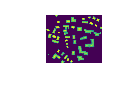

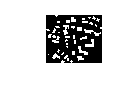

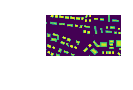

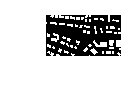

In [7]:
testPath = r"Data/Testing/"
tmpPath = r"../tmp_data/weights_sester/trainGeb15/"
outPath = r"../tmp_data/results_sester/Geb15/"


all_records = []

records = predict_15k(tmpPath, testPath, outPath, 
                      r"FTest1_input_inv.png", r"FTest1_output_inv.png")
all_records.extend(records)

records = predict_15k(tmpPath, testPath, outPath, 
                      r"FTest2_input_inv.png", r"FTest2_output_inv.png")
all_records.extend(records)

df = pd.DataFrame(np.transpose(all_records))
df.columns = ["Input vs Target (Test1)", "Prediction vs Target (Test1)", 
              "Input vs Target (Test2)", "Prediction vs Target (Test2)"]

df = df.rename({0: "Accuracy", 1: 'IoU'})
df.index.name = 'Metrics'
df

Input and Target: geb_clip_4270.png geb25_clip_4270.png
25 Example: 
accuracy: 0.98175058548
IoU: 0.883636092131
accuracy: 0.987819810477
IoU: 0.920298981475
Input and Target: geb_clip_4270.png geb15_clip_4270.png
15 Example: 
accuracy: 0.990798448478
IoU: 0.939490302169
accuracy: 0.993723707933
IoU: 0.95820280161
Input and Target: geb_clip_4270.png geb10_clip_4270.png
10 Example: 
accuracy: 0.994788952722
IoU: 0.965207613366
accuracy: 0.993604156895
IoU: 0.95718225691


,Input vs Target (25k),Prediction vs Target (25k),Input vs Target (15k),Prediction vs Target (15k),Input vs Target (10k),Prediction vs Target (10k)
Metrics,,,,,,
Accuracy,0.981751,0.987820,0.990798,0.993724,0.994789,0.993604
IoU,0.883636,0.920299,0.939490,0.958203,0.965208,0.957182


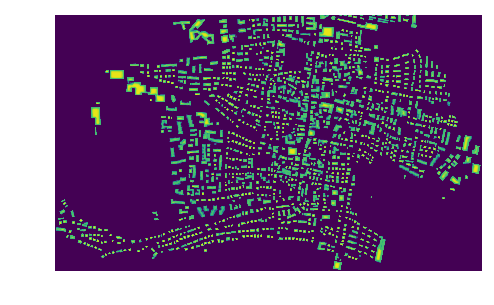

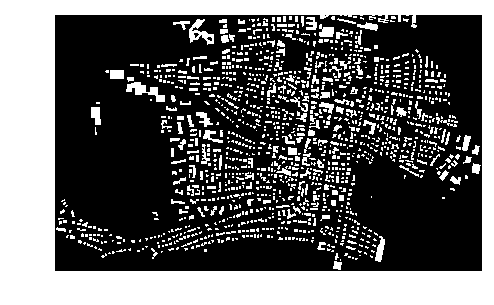

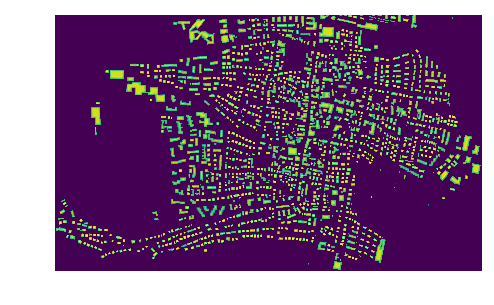

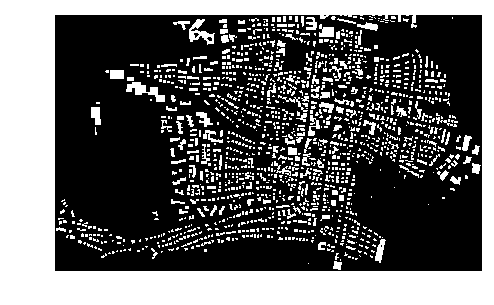

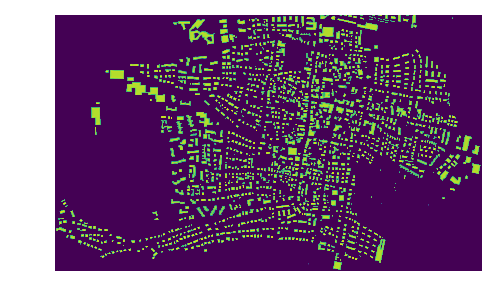

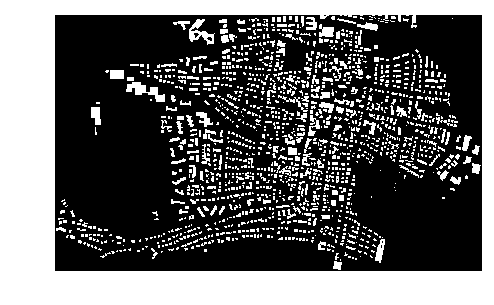

In [8]:
all_records = []
testPath = r"Data/Testing_large/4270/"

scale = 25
tmpPath = r"../tmp_data/weights_sester/trainGeb25/"
outPath = r"../tmp_data/results_sester/Geb25/"

records = predict_scale(tmpPath, testPath, outPath, scale)
all_records.extend(records)

scale = 15
tmpPath = r"../tmp_data/weights_sester/trainGeb15/"
outPath = r"../tmp_data/results_sester/Geb15/"
records = predict_scale(tmpPath, testPath, outPath, scale)
all_records.extend(records)

scale = 10
tmpPath = r"../tmp_data/weights_sester/trainGeb10/"
outPath = r"../tmp_data/results_sester/Geb10/"
records = predict_scale(tmpPath, testPath, outPath, scale)
all_records.extend(records)

df = pd.DataFrame(np.transpose(all_records))
df.columns = ["Input vs Target (25k)", "Prediction vs Target (25k)", 
              "Input vs Target (15k)", "Prediction vs Target (15k)",
              "Input vs Target (10k)", "Prediction vs Target (10k)"]

df = df.rename({0: "Accuracy", 1: 'IoU'})
df.index.name = 'Metrics'
df